In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

from sklearn.preprocessing import StandardScaler

import cmdstanpy
from cmdstanpy import CmdStanModel

In [3]:
df = pd.read_csv("df_balanced.csv")

In [8]:
from cmdstanpy import CmdStanModel

stan_code = r"""
data {
  int<lower=1> N;                         // numero di osservazioni
  int<lower=1> I;                         // numero di donatori
  int<lower=1> K;                         // numero di target (K=5)
  int<lower=1> P;                         // numero di covariate

  array[N] int<lower=1, upper=I> id;      // indice donatore
  matrix[N, K] Y;                         // target
  matrix[N, P] X;                         // covariate

  real<lower=0> tau0;                     // scala globale per regularized horseshoe
}

parameters {
  // ---------- Regularized Horseshoe ----------
  matrix[P, K] beta_tilde;                // coefficienti standardizzati
  vector<lower=0>[P] lambda;              // shrinkage locale
  real<lower=0> tau;                      // shrinkage globale
  real<lower=0> c2_tilde;                 // slab parameter

  // ---------- Random effects non-centered ----------
  matrix[I, K] z_b;                        // effetti random standardizzati
  vector<lower=0>[K] tau_b;                // scale random effects
  cholesky_factor_corr[K] L_Omega_b;       // LKJ per random effects

  // ---------- Residual covariance ----------
  vector<lower=0>[K] tau_eps;              // scale residuals
  cholesky_factor_corr[K] L_Omega_eps;     // LKJ per residui
}

transformed parameters {
  // beta dopo regularized horseshoe
  matrix[P, K] beta;
  real<lower=0> c2;
  c2 = square(tau) * c2_tilde;

  for (p in 1:P) {
    real lambda_tilde = sqrt( (c2 * square(lambda[p])) / (c2 + square(tau) * square(lambda[p])) );
    for (k in 1:K) {
      beta[p, k] = beta_tilde[p, k] * lambda_tilde * tau;
    }
  }

  // effetti random non-centered
  matrix[K, K] L_Sigma_b = diag_pre_multiply(tau_b, L_Omega_b);
  matrix[K, I] b_t = L_Sigma_b * z_b';
  matrix[I, K] b = b_t';

  // residui
  matrix[K, K] L_Sigma = diag_pre_multiply(tau_eps, L_Omega_eps);
}

model {
  // ---------- Priori horseshoe ----------
  to_vector(beta_tilde) ~ normal(0, 1);
  lambda ~ cauchy(0, 1);
  tau ~ cauchy(0, tau0);
  c2_tilde ~ inv_gamma(2, 8);

  // ---------- Random effects ----------
  tau_b ~ normal(0, 0.5) T[0, ];
  L_Omega_b ~ lkj_corr_cholesky(4);
  to_vector(z_b) ~ normal(0, 1);

  // ---------- Residuals ----------
  tau_eps ~ normal(0, 0.5) T[0, ];
  L_Omega_eps ~ lkj_corr_cholesky(4);

  // ---------- Likelihood ----------
  for (n in 1:N) {
    row_vector[K] mu_n = X[n] * beta + b[id[n]];
    Y[n] ~ multi_normal_cholesky(mu_n, L_Sigma);
  }
}
"""

stan_file = "model2_SESSO.stan"
with open(stan_file, "w") as f:
    f.write(stan_code)

print("Stan model written to:", stan_file)

model = CmdStanModel(stan_file=stan_file)
print("Model compiled.")

12:49:27 - cmdstanpy - INFO - compiling stan file /var/folders/97/_n7g3p_94wb_zs30j_q45kbc0000gn/T/tmpdu869551/tmpx4ma1_k_.stan to exe file /Users/martinacaliandro/Downloads/BS Project/model2_SESSO


Stan model written to: model2_SESSO.stan


12:49:38 - cmdstanpy - INFO - compiled model executable: /Users/martinacaliandro/Downloads/BS Project/model2_SESSO


Model compiled.


In [12]:
model = CmdStanModel(stan_file=stan_file)
ID_COL = "CAI"
ADD_INTERCEPT = False
target_list = ['PMAX', 'Glucosio', 'Trigliceridi', 'Colesterolo_Hdl', 'BMI']
covariate_cols = df.columns.drop(list(target_list) + [ID_COL])

cols_needed = [ID_COL] + target_list + list(covariate_cols)
df_model = df[cols_needed].dropna().copy()

Y_mat = df_model[target_list].to_numpy(dtype=float)
N, K = Y_mat.shape
X_mat = df_model[covariate_cols].to_numpy(dtype=float)
_, P = X_mat.shape

donor_ids, id_index = np.unique(df_model[ID_COL].to_numpy(), return_inverse=True)
I = len(donor_ids)
id_stan = id_index + 1

stan_data = {
    "N": int(N),
    "I": int(I),
    "K": int(K),
    "P": int(P),
    "Y": Y_mat,
    "X": X_mat,
    "id": id_stan,
    "tau0": 0.002
}

In [13]:
fit = model.sample(
    data=stan_data,
    chains=4,
    parallel_chains=4,
    iter_warmup=1500,
    iter_sampling=1000,
    adapt_delta=0.9,
    max_treedepth=12,
    show_progress=True
)
print(fit.diagnose())

12:50:55 - cmdstanpy - INFO - CmdStan start processing


chain 1:   0%|          | 0/2500 [00:00<?, ?it/s, (Warmup)]

chain 2:   0%|          | 0/2500 [00:00<?, ?it/s, (Warmup)]

chain 3:   0%|          | 0/2500 [00:00<?, ?it/s, (Warmup)]

chain 4:   0%|          | 0/2500 [00:00<?, ?it/s, (Warmup)]

17:34:51 - cmdstanpy - INFO - CmdStan done processing.
17:34:51 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'model2_SESSO.stan', line 63, column 2 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'model2_SESSO.stan', line 63, column 2 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'model2_SESSO.stan', line 63, column 2 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'model2_SESSO.stan', line 63, column 2 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'model2_SESSO.stan', line 63, column 2 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'model2_SESSO.stan', line 63, column 2 to column 35)
	Exception: lkj_corr_cholesky_lpdf: Rand

17:34:51 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 999 iterations at max treedepth (99.9%)
	Chain 3 had 999 iterations at max treedepth (99.9%)
	Chain 4 had 999 iterations at max treedepth (99.9%)
	Use the "diagnose()" method on the CmdStanMCMC object to see further information.


Checking sampler transitions treedepth.
3000 of 4000 (75.00%) transitions hit the maximum treedepth limit of 12, or 2^12 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.25, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  beta_tilde[3,1], beta_tilde[6,1], beta_tilde[19,1], beta_tilde[20,1], beta_tilde[21,1], beta_tilde[11,2], beta_tilde[19,2], beta_tilde[20,2], beta_tilde[21,2], beta_tilde[3,3], beta_tilde[19,3], beta_tilde[20,3], beta_tilde[21,3], beta_tilde[3,4

In [14]:
print(fit.diagnose())
summary_df = fit.summary()
summary_df.head(50)

Checking sampler transitions treedepth.
3000 of 4000 (75.00%) transitions hit the maximum treedepth limit of 12, or 2^12 leapfrog steps.
Trajectories that are prematurely terminated due to this limit will result in slow exploration.
For optimal performance, increase this limit.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
The E-BFMI, 0.25, is below the nominal threshold of 0.30 which suggests that HMC may have trouble exploring the target distribution.
If possible, try to reparameterize the model.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  beta_tilde[3,1], beta_tilde[6,1], beta_tilde[19,1], beta_tilde[20,1], beta_tilde[21,1], beta_tilde[11,2], beta_tilde[19,2], beta_tilde[20,2], beta_tilde[21,2], beta_tilde[3,3], beta_tilde[19,3], beta_tilde[20,3], beta_tilde[21,3], beta_tilde[3,4

,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
lp__,10003.100000,21.202400,34.984300,30.844000,9936.670000,10011.600000,10050.300000,6.91576,2000.000,0.000309,1.58261
"beta_tilde[1,1]",-0.099210,0.020576,0.589805,0.484285,-1.040750,-0.098045,0.851379,916.37400,813.121,0.040955,1.00674
"beta_tilde[1,2]",0.904605,0.027477,0.716055,0.618056,-0.203957,0.872938,2.118470,688.93200,605.286,0.030790,1.00454
"beta_tilde[1,3]",0.656066,0.035356,0.977880,0.964977,-1.028450,0.712968,2.156720,831.38100,1062.390,0.037157,1.00710
"beta_tilde[1,4]",0.560662,0.024999,0.687840,0.649036,-0.505760,0.539269,1.756530,779.51200,865.095,0.034839,1.00980
"beta_tilde[1,5]",0.604685,0.018113,0.482973,0.398821,-0.000149,0.524713,1.489740,808.54900,892.249,0.036136,1.01076
"beta_tilde[2,1]",0.360422,0.018366,0.519310,0.454767,-0.425549,0.335630,1.254660,808.97300,1069.500,0.036155,1.00254
"beta_tilde[2,2]",-0.609645,0.025525,0.638341,0.562598,-1.672570,-0.592478,0.408500,665.36800,878.351,0.029737,1.00723
"beta_tilde[2,3]",0.225788,0.028601,0.876125,0.861525,-1.224840,0.237762,1.654040,939.89600,1514.530,0.042007,1.00626
"beta_tilde[2,4]",1.281700,0.024948,0.680271,0.646586,0.245521,1.260030,2.444510,779.78800,792.779,0.034851,1.00686


In [28]:
summary_df[
    (summary_df["R_hat"] > 1.01) |
    (summary_df["ESS_bulk"] < 400)
]
summary_df.sort_values("R_hat", ascending=False).head(10)


,Mean,MCSE,StdDev,MAD,5%,50%,95%,ESS_bulk,ESS_tail,ESS_bulk/s,R_hat
"b_t[5,18]",1.26280,1.07208,1.52523,1.73936,-0.670813,0.932537,3.48953,4.55500,2000.0,0.000204,3.00032
"b[18,5]",1.26280,1.07208,1.52523,1.73936,-0.670813,0.932537,3.48953,4.55500,2000.0,0.000204,3.00032
"b[18,1]",1.55623,1.55381,2.21075,2.43509,-1.198400,1.066280,4.81968,4.55983,2000.0,0.000204,2.98840
"b_t[1,18]",1.55623,1.55381,2.21075,2.43509,-1.198400,1.066280,4.81968,4.55983,2000.0,0.000204,2.98840
"b[18,2]",1.45338,1.46354,2.08223,2.29990,-1.126690,0.966995,4.54092,4.55978,2000.0,0.000204,2.98835
"b_t[2,18]",1.45338,1.46354,2.08223,2.29990,-1.126690,0.966995,4.54092,4.55978,2000.0,0.000204,2.98835
"b_t[3,18]",1.81626,1.53001,2.17858,2.49337,-1.007240,1.379100,4.98985,4.56418,2000.0,0.000204,2.98459
"b[18,3]",1.81626,1.53001,2.17858,2.49337,-1.007240,1.379100,4.98985,4.56418,2000.0,0.000204,2.98459
"b[22,2]",2.06086,1.14485,1.63150,1.53965,0.152423,1.567670,4.64664,4.55946,2000.0,0.000204,2.97633
"b_t[2,22]",2.06086,1.14485,1.63150,1.53965,0.152423,1.567670,4.64664,4.55946,2000.0,0.000204,2.97633


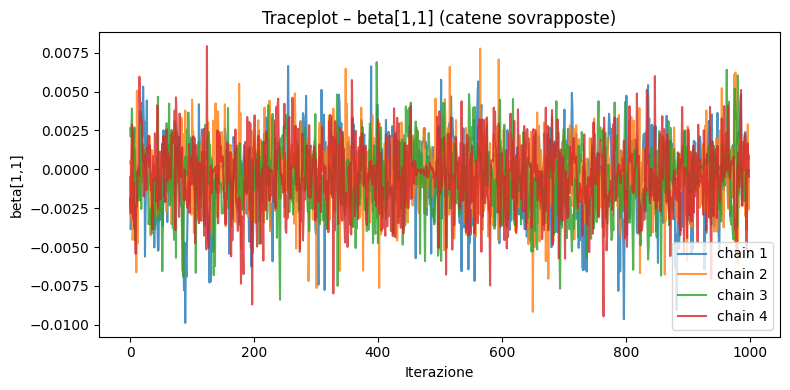

In [15]:
# Interesting plots

beta = fit.stan_variable("beta")
tot_draws, P, K = beta.shape
chains = fit.chains # number of chains
iters = tot_draws // chains # number of draws per chain

beta_chains = beta.reshape(chains, iters, P, K)

fig, ax = plt.subplots(figsize=(8, 4))

for c in range(chains):
    ax.plot(beta_chains[c, :, 0, 0], label=f"chain {c+1}", alpha=0.8)

ax.set_xlabel("Iterazione")
ax.set_ylabel(f"beta[{0+1},{0+1}]")
ax.set_title(f"Traceplot – beta[{0+1},{0+1}] (catene sovrapposte)")
ax.legend()
plt.tight_layout()
plt.show()

In [21]:
with open("Model_2_SESSO.pkl", "wb") as f:
    pickle.dump(fit, f)

In [23]:
import pickle
with open("Model_2_SESSO.pkl", "rb") as f:
    fit = pickle.load(f)

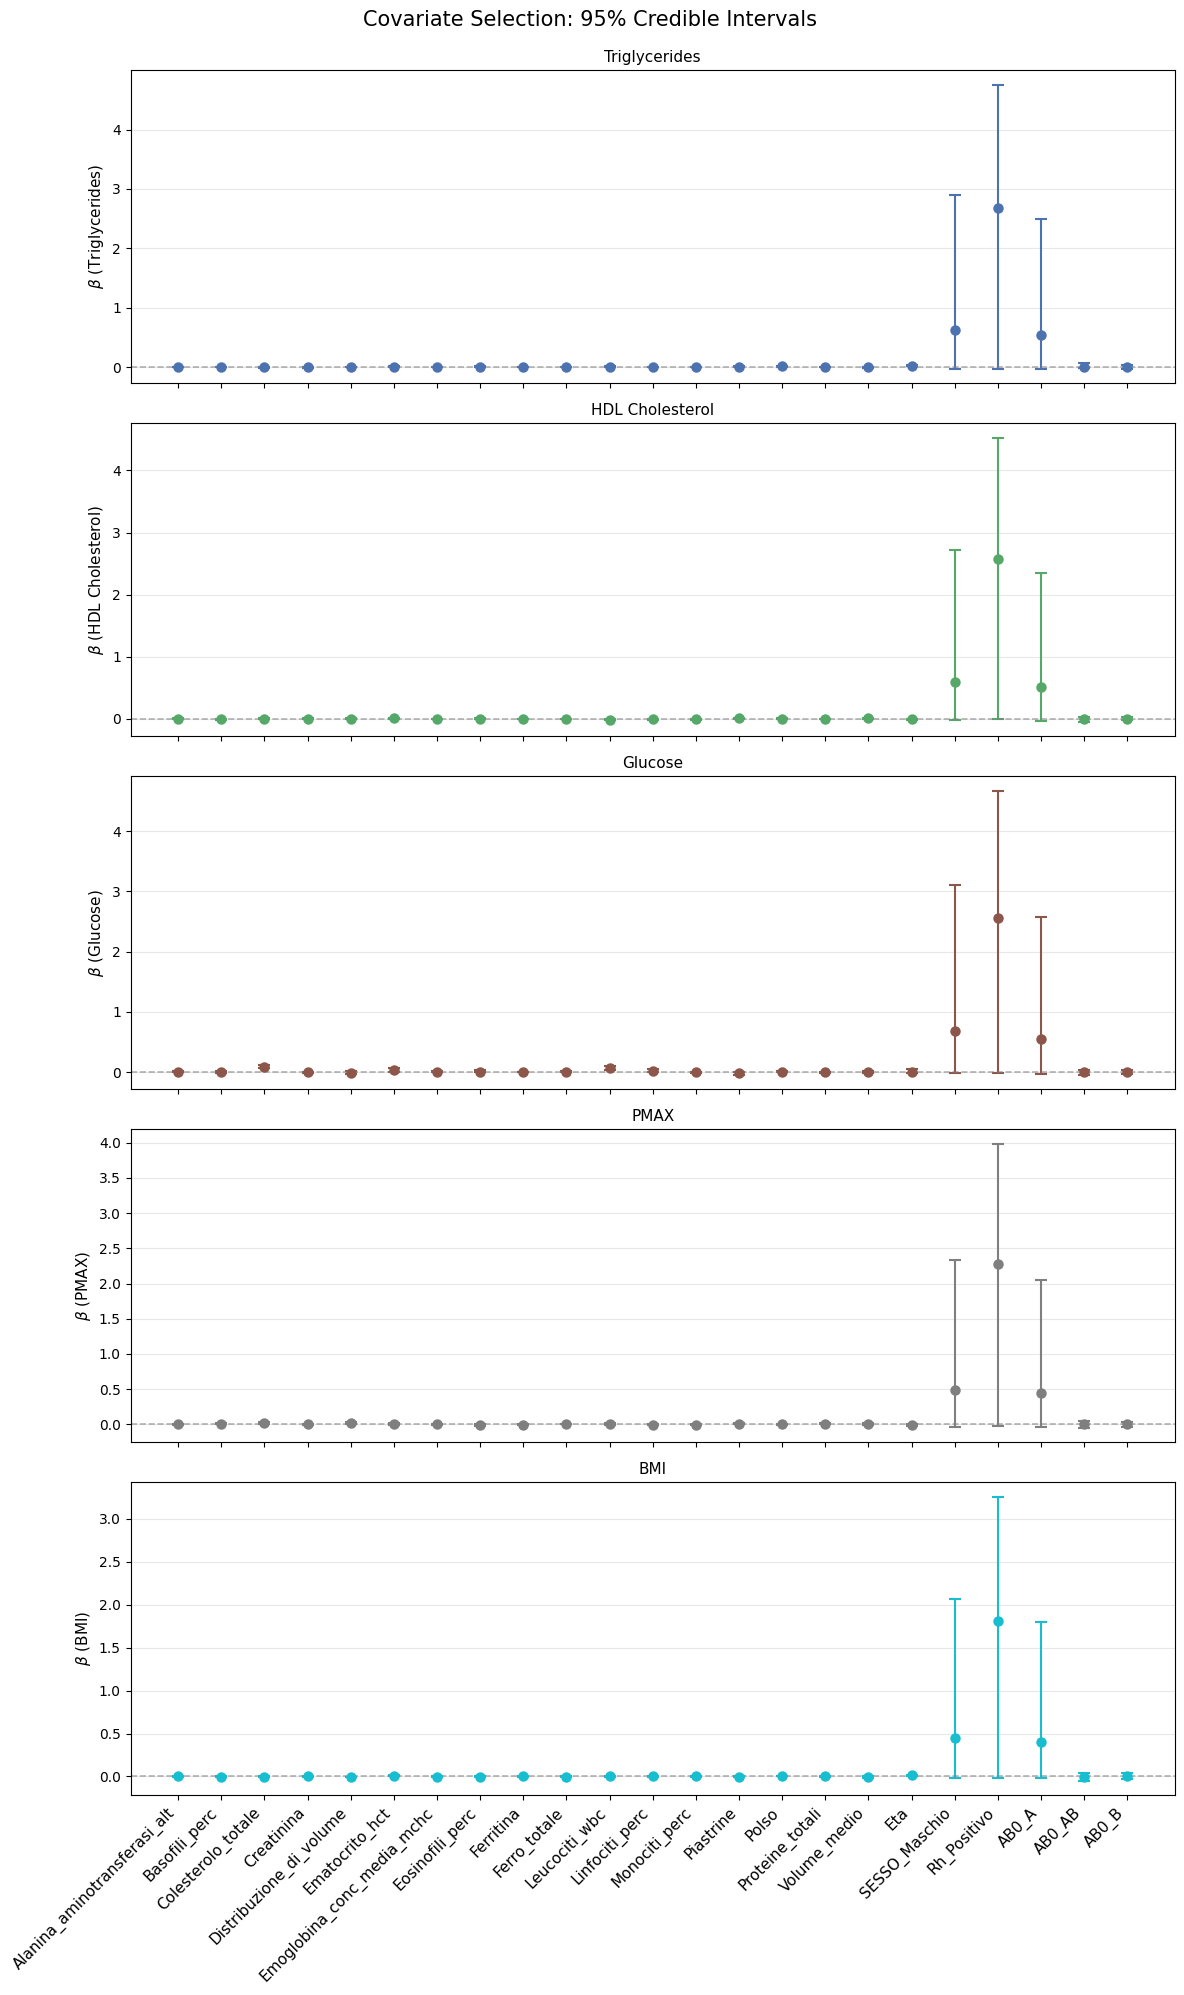

In [25]:
import matplotlib.pyplot as plt
ID_COL = "CAI"
TARGET_COLS = ["Trigliceridi", "Colesterolo_Hdl", "Glucosio", "PMAX", "BMI"]
numeric_cols = df.select_dtypes(exclude=["object", "category"]).columns.tolist()
COVARIATE_COLS = [c for c in numeric_cols if c not in TARGET_COLS + [ID_COL]]

data = fit.stan_variables()
beta_samples = data['beta']

if beta_samples.ndim == 3 and beta_samples.shape[-1] == 5:
    beta_samples = np.swapaxes(beta_samples, 1, 2)

n_targets = beta_samples.shape[1]
n_features = beta_samples.shape[2]

means = np.mean(beta_samples, axis=0)              # Shape: (n_targets, n_features)
lower = np.percentile(beta_samples, 2.5, axis=0)   # Shape: (n_targets, n_features)
upper = np.percentile(beta_samples, 97.5, axis=0)  # Shape: (n_targets, n_features)

y_pos = np.arange(n_features)
target_names = ['Triglycerides', 'HDL Cholesterol', 'Glucose', 'PMAX', 'BMI']
colors = ['#4c72b0', '#55a868', '#8c564b', '#7f7f7f', '#17becf']

fig, axes = plt.subplots(nrows=n_targets, ncols=1,
                         figsize=(12, 4 * n_targets),
                         sharex=True)

if n_targets == 1: axes = [axes]

for i, ax in enumerate(axes):
    y_mean = means[i, :]
    y_low = lower[i, :]
    y_high = upper[i, :]
    y_err = [y_mean - y_low, y_high - y_mean]
    col = colors[i % len(colors)]
    ax.errorbar(x=y_pos, y=y_mean, yerr=y_err, fmt='o',
                markersize=6, capsize=4,
                color=col, ecolor=col,
                elinewidth=1.5, markeredgewidth=1.5)
    ax.axhline(y=0, color='gray', linestyle='--', linewidth=1.2, alpha=0.6)
    if i < len(target_names):
        t_name = target_names[i]
    else:
        t_name = f"Target {i+1}"

    ax.set_title(t_name, fontsize=11)
    ax.set_ylabel(fr'$\beta$ ({t_name})', fontsize=11)
    ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
    ax.set_axisbelow(True)

axes[-1].set_xticks(y_pos)
axes[-1].set_xticklabels(COVARIATE_COLS, rotation=45, ha='right', fontsize=11)

fig.suptitle('Covariate Selection: 95% Credible Intervals', fontsize=15, y=0.995)

plt.tight_layout()
plt.show()